In [1]:
from preprocessing.data_cleaning import get_cleaned_data, split_csv, get_features_label
from preprocessing.encoding import encode_data
from exploration.data_correlations import plot_correlations
from exploration.data_statistics import plot_labels_pie_chart, plot_blood_draw_statistics
from utils.utils import log_features
from modeling.mrmr import perform_mrmr
from modeling.RandomForest import run_random_forest

In [2]:
df = encode_data(get_cleaned_data())
df = df[df["P1_PT_TYPE"] != 3]
log_features(df)
blood, clinical = split_csv(df)

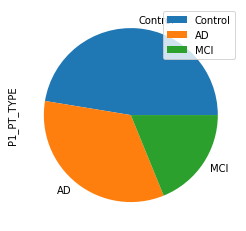

In [3]:
plot_labels_pie_chart(df, png="Pie Chart of Diagnoses")

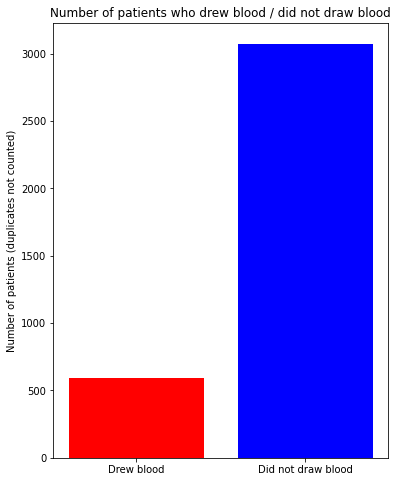

In [4]:
plot_blood_draw_statistics(df, png="Blood Draw Proportions")

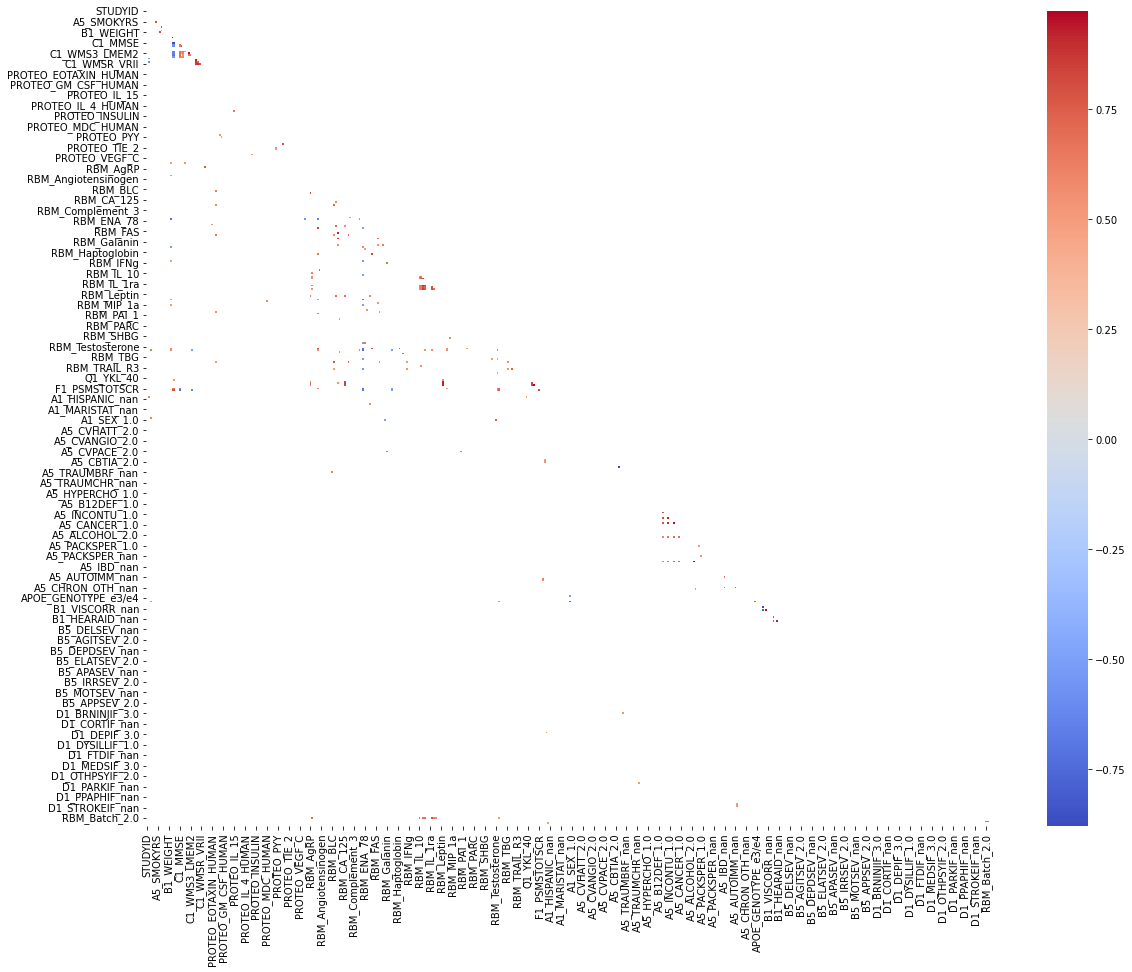

In [5]:
plot_correlations(df)

In [6]:
import pandas as pd
import numpy as np

y, X = get_features_label(df)
y = pd.Series(y)
(features, score, redundancy_matrix) = perform_mrmr(X, y, X.shape[1], scr = True)
score = score.sort_values(ascending=False)
score = score.reset_index()

pairs = {}
for num_features in range(1,X.shape[1]):
    print(num_features)
    test_df = df[score['index'][:num_features]]
    test_df["P1_PT_TYPE"] = df["P1_PT_TYPE"]
    micro_f1_score = test_mrmr_model(test_df)
    pairs[num_features] = micro_f1_score

  4%|▎         | 15/421 [00:04<01:48,  3.74it/s]


KeyboardInterrupt: 

In [7]:
import pandas as pd

y, X = get_features_label(df)
y = pd.Series(y)

features, score = perform_mrmr(X, y, 10, True)

100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


ValueError: too many values to unpack (expected 2)

In [7]:
micro_f1_scores, feature_importances, confusion_matrices = run_random_forest(clinical)

In [9]:
print(micro_f1_scores[0])

[0.95376121]


In [11]:
print(feature_importances[0][:10])

Index(['C1_CDRSUM', 'C1_CDRGLOB', 'F2_IADLTOTSCR', 'C1_MMSE', 'C1_WMSR_LMEM1',
       'STUDYID', 'C1_SS_TRAILB', 'C1_WMS3_LMEM1', 'C1_WMS3_LMEM2',
       'A1_HISPANIC_1.0'],
      dtype='object')


In [12]:
print(confusion_matrices[0])

[[ 941    0   41]
 [   1 1319   37]
 [  36   19  504]]


In [9]:
import pandas as pd
label_encoded_df = pd.get_dummies(blood, columns=["P1_PT_TYPE"])

correlations = blood.corr().abs().unstack()
ad_correlations = correlations["P1_PT_TYPE"].sort_values()
print(ad_correlations.index[:100])

Index(['RBM_IFNg', 'A5_TRAUMBRF_1.0', 'D1_BRNINJIF_3.0', 'A5_TOBAC30_nan',
       'A5_CVPACE_2.0', 'A5_CVCHF_1.0', 'RBM_MPO', 'C1_WMSR_VRI',
       'RBM_Progesterone', 'PROTEO_MIP_1B_HUMAN', 'PROTEO_LBP',
       'B1_VISWCORR_1.0', 'PROTEO_CLUSTERIN', 'RBM_BMP6', 'PROTEO_INSULIN',
       'RBM_BDNF', 'RBM_Batch_3.0', 'A5_TRAUMBRF_2.0', 'RBM_Fibrinogen',
       'A5_HYPERTEN_1.0', 'A42_VEAS', 'RBM_TGF_alpha', 'RBM_Testosterone',
       'PROTEO_BFGF', 'RBM_MIF', 'A5_PACKSPER_3.0', 'PROTEO_VEGF_C',
       'RBM_Sortilin', 'RBM_EN_RAGE', 'STUDYID', 'PROTEO_IL_15',
       'RBM_Batch_2.0', 'B1_VISCORR_1.0', 'RBM_CA_19_9', 'PROTEO_TIE_2',
       'RBM_APO_CIII', 'RBM_BTC', 'RBM_SGOT', 'RBM_IL_16', 'PROTEO_CRP',
       'RBM_ANG_2', 'A5_THYROID_2.0', 'A5_CVBYPASS_1.0', 'RBM_Epiregulin',
       'RBM_TIMP_1', 'PROTEO_IL_7_HUMAN', 'A1_MARISTAT_6.0', 'A5_CVCHF_2.0',
       'A5_TOBAC100_nan', 'RBM_sRAGE', 'RBM_MDC', 'RBM_APO_H', 'RBM_ICAM_1',
       'A5_CVANGIO_2.0', 'RBM_Lpa', 'A5_HYPERCHO_nan', 'RBM_Am